# Funkcje Pomocnicze do Zadania

Aby wszystkie funkcje zadziałały, notebook powinien być uruchamiany z następującym ułożeniem katalogów:

```
|- helpers.ipynb
|- sampleSubmission.csv
|- train
 |- {unzipped train files and labels}
|- test
 |- {unzipped test files}
```

Należy odkomentować u siebie linijki zapisujące pliki.

In [1]:
!conda install -c conda-forge -y librosa


CondaHTTPError: HTTP 000 CONNECTION FAILED for url <https://repo.anaconda.com/pkgs/main/linux-64/repodata.json.bz2>
Elapsed: -

An HTTP error occurred when trying to retrieve this URL.
HTTP errors are often intermittent, and a simple retry will get you on your way.

If your current network has https://www.anaconda.com blocked, please file
a support request with your network engineering team.

ConnectionError(MaxRetryError("HTTPSConnectionPool(host='repo.anaconda.com', port=443): Max retries exceeded with url: /pkgs/main/linux-64/repodata.json.bz2 (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f02d4bbc748>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution',))",),)




In [2]:
import os

import librosa
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import roc_auc_score
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm, trange

# Wczytywanie Danych

Poniższe funkcje są przykładowymi funkcjami wczytującymi dane. Możliwe, że będą potrzebne modyfikacje reprezentacji i bardziej skomplikowana funkcja tworząca zbiór treningowy. Wczytywanie danych nie jest zaimplementowane optymalnie - między innymi kod wczytuje wielokrotnie ten sam plik. Dla bardziej złożonych reprezentacji możliwe, że trzeba będzie przepisać te funkcje.

In [3]:
def load_mel(file_name, start=0, stop=None, n_mels=60):
    """czytuje mel spektrogram z pliku.
    
    Args:
        file_name (str): Nazwa pliku z nagraniem.
        start (float): Sekunda, w której zaczyna się interesujący fragment.
        stop (float): Sekunda, w której kończy się interesujący fragment.
        n_mels (int): Liczba meli na spektrogramie (wysokość spektrogramu).
    
    Returns:
        ndarray: Spektrogram.
    """
    samples, sample_rate = librosa.core.load(file_name, sr = None)
    samples = samples[int(start * sample_rate):int(stop * sample_rate) if stop else None]
    spectrogram = librosa.feature.melspectrogram(y = samples, sr = sample_rate,
                                                 n_mels = n_mels, fmin = 4000, fmax = 9500)
    return spectrogram


# def load_spec(file_name, start=0, stop=None):
#     """Wczytuje standardowy spektrogram z pliku.
#     
#     Args:
#         file_name (str): Nazwa pliku z nagraniem.
#         start (float): Sekunda, w której zaczyna się interesujący fragment.
#         stop (float): Sekunda, w której kończy się interesujący fragment.
#     
#     Returns:
#         ndarray: Spektrogram.
#     """
#     sample_rate, samples = wavfile.read(file_name)
#     samples = samples[int(start * sample_rate):int(stop * sample_rate) if stop else None]
#     _, _, spectrogram = signal.spectrogram(samples, sample_rate)
#     return spectrogram


def load_test(load_repr=load_mel):
    """Wczytuje dane testowe.
    
    Args:
        load_repr (function): Funkcja wczytująca pożądaną reprezentację.
    
    Returns:
        ndarray: Tablica z danymi testowymi.
    """
    with open('sampleSubmission.csv', 'r') as file:
        lines = file.read().split()[1:]
        sample_ids = [line.split(',')[0] for line in lines]
        samples = np.array([s.split('/') for s in sample_ids])
    
    X_test = []
    rec_files = [file_name for file_name in os.listdir('test') if file_name.endswith('.wav')]
    for file_name in rec_files:
        recording_id = file_name.split('.')[0][3:]
        time_markers = samples[samples[:, 0] == recording_id, 1].astype(np.int)
        for t in time_markers:
            representation = load_repr(os.path.join('test', file_name), start = t, stop = t + 1)
            X_test.append(representation)
    return np.array(X_test)


def read_labels():
    """Wczytuje etykiety czasowe z pliku labels.txt w folderze train.
    
    Returns:
        ndarray: Tablica z etykietami czasowymi zawierająca kolumny: nr nagrania, sekunda początku dźwięku, sekunda końca dźwięku.
    """
    labels = []
    with open(os.path.join('train', 'labels.txt'), 'r') as file:
        text = file.read()
        for line in text.split('\n')[1:]:
            if len(line) > 1:
                rec, start, stop = line.split(',')
                rec, start, stop = int(rec[3:]), float(start), float(stop)
                labels.append([rec, start, stop])
    return np.array(labels)


def check_voices(second, labels, tol=0.):
    """Sprawdza czy w ramce czasowej [second, second+1] znajduje się głos według etykiet `labels`.
    
    Args:
        second (float): Sekunda nagrania.
        labels (ndarray): Tablica z etykietami, której 2 kolumna oznacza początek, a 3-cia - koniec nagrania.
        tol (float): Tolerancja na brzegach fragmentu. Dźwięk, żeby był uznany, musi się kończyć po czasie `second+tol`
            lub zaczynać przed czasem `second+1-tol`.
    Returns:
        bool: Czy w ramce czasowej jest odgłos ptaka.
    """
    return (labels[1] >= second and labels[1] < second + 1 - tol) or \
           (labels[2] < second + 1 and labels[2] > second + tol) or \
           (labels[1] < second and labels[2] > second + 1)


def map_seconds_to_y(labels):
    """Tworzy etykiety dla każdej kolejnej sekundy 10-sekundowego nagrania. -1 oznacza niepewną etykietę (urwane dźwięki na brzegach).
    
    Args:
        labels (ndarray): Tablica z etykietami, której 2 kolumna oznacza początek, a 3-cia - koniec nagrania.
    Returns:
        ndarray: Tablica z binarnymi etykietami dla każdej z 10 sekund z możliwą niepewną etkietą -1.
    """
    y = [0] * 10
    y_restrictive = [0] * 10
    for s in range(10):
        for l in labels:
            if check_voices(s, l):
                y[s] = 1
            if check_voices(s, l, 0.02):
                y_restrictive[s] = 1
        if y[s] != y_restrictive[s]:
            y[s] = -1
    return y


def load_train(load_repr=load_mel):
    """Wczytuje dane treningowe.
    
    Args:
        load_repr (function): Funkcja wczytująca pożądaną reprezentację.
    
    Returns:
        (ndarray, ndarray): Tablica z danymi treningowymi, tablica z binarnymi etykietami treningowymi.
    """
    labels = read_labels()
    X_train, y_train = [], []
    rec_files = [file_name for file_name in os.listdir('train') if file_name.endswith('.wav')]
    for file_name in rec_files:
        recording_id = int(file_name.split('.')[0][3:])
        recording_labels = labels[labels[:, 0] == recording_id]
        y_binary = map_seconds_to_y(recording_labels)
        for i, y in enumerate(y_binary):
            if y != -1:
                try:
                    representation = load_repr(os.path.join('train', file_name), start = i, stop = i + 1)
                    X_train.append(representation)
                    y_train.append(y)
                except ValueError:
                    print('Error reading file', file_name)
                except TypeError:
                    print('Unsupported type', file_name)
    return np.array(X_train), np.array(y_train)

# Zapisywanie Wczytanej Reprezentacji

Ponieważ tworzenie reprezentacji może zabierać sporo czasu (szczególnie w tak naiwnej implementacji jak powyższa), warto zapisać wczytane dane do plików.

In [4]:
# Poniższa linijka ustawia folder główny
os.chdir('../input/')

X_test = load_test()
# np.save(os.path.join('test', 'tmp_X_test'), X_test)

X, y = load_train()
# np.save(os.path.join('train', 'tmp_X_train'), X)
# np.save(os.path.join('train', 'tmp_y_train'), y)

Unsupported type rec246.wav
Unsupported type rec246.wav
Unsupported type rec246.wav
Unsupported type rec246.wav
Unsupported type rec246.wav
Unsupported type rec246.wav
Unsupported type rec246.wav
Unsupported type rec246.wav
Unsupported type rec246.wav
Unsupported type rec246.wav


# Model i Trenowanie

Poniższy przykład używa poprawnych metryk i zapisuje parametry modelu.

In [5]:
class Detector(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(60 * 87, 2)
    
    def forward(self, x):
        out = torch.flatten(x, start_dim = 1)
        out = self.linear(out)
        return out
    
clf = Detector()

In [6]:
# Dzielenie zbioru danych na treningowy i walidacyjny
split_point = int(len(X) * 0.8)

X_train = torch.Tensor(X[:split_point])
y_train = torch.LongTensor(y[:split_point])

X_valid = torch.Tensor(X[split_point:])
y_valid = torch.LongTensor(y[split_point:])

batch_size = 64

dataset = TensorDataset(X_train, y_train)
data_loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

valid_dataset = TensorDataset(X_valid, y_valid)
valid_data_loader = DataLoader(valid_dataset, batch_size = batch_size)

In [7]:
# Ustawienie kosztu i optimizera
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(clf.parameters())

# Pętla uczenia
best_preds, best_score = None, 0.
losses, scores = [], []
for epoch in trange(10):
    running_loss = 0
    clf.train()
    for X, y in data_loader:
        optimizer.zero_grad()

        outputs = clf(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    losses.append(running_loss)
    
    clf.eval()
    preds = []
    for X, _ in valid_data_loader:
        out = clf(X)
        preds.append(torch.softmax(out, dim = 1)[:, 1].detach().numpy())
    preds = np.concatenate(preds, axis = 0)
    
    # Metryką testującą jest ROC AUC
    score = roc_auc_score(y_valid.numpy(), preds)
    scores.append(score)
    if score > best_score:
        best_score = score
        best_preds = preds
        # np.save('tmp_preds', best_preds)
        
        # Model dający najlepszy wynik powinien być zapisany
        # torch.save(clf.state_dict(), 'tmp_model.pt')

100%|██████████| 10/10 [00:01<00:00,  9.11it/s]


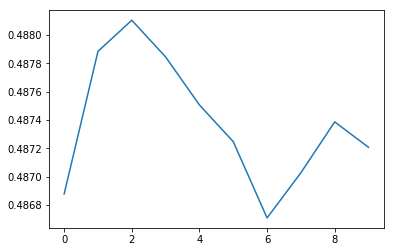

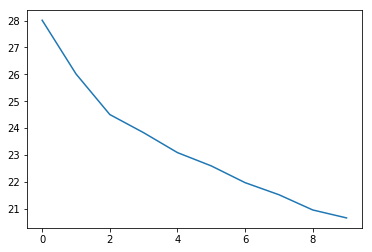

In [8]:
# Rysowanie lossu i AUC

import matplotlib.pyplot as plt

%matplotlib inline

plt.plot(scores)
plt.show()

plt.plot(losses)
plt.show()

# Zapis Predykcji

In [9]:
def save_predictions(preds):
    """Zapisuje predykcje do pliku zgodnego z formatem odpowiedzi.
    
    Args:
        preds (list): Lista predykcji (prawdopodobieństw).
    """
    with open('sampleSubmission.csv', 'r') as file:
        submission_text = file.read().split()
        header = submission_text[0]
        lines = submission_text[1:]

    output_lines = [header]
    for pred, line in zip(preds, lines):
        output_lines.append("{},{}".format(line.split(',')[0], pred))
    
    with open('mySubmission.csv', 'w') as file:
        file.write('\n'.join(output_lines) + '\n')

In [10]:
# Wczytanie najlepszego modelu
# clf.load_state_dict('tmp_model.pt')

# Tworzenie data loadera testowego
X_test_tensor = torch.Tensor(X_test)

test_dataset = TensorDataset(X_test_tensor)
test_data_loader = DataLoader(test_dataset, batch_size = batch_size)

# Ewaluacja modelu na danych testowych
clf.eval()
preds = []
for X in test_data_loader:
    out = clf(X[0])
    preds.append(torch.softmax(out, dim = 1)[:, 1].detach().numpy())
preds = np.concatenate(preds, axis = 0)

# Zapisanie predykcji do poprawnego formatu
# save_predictions(preds)